<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [1]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 8
EPOCHS = 15
PADDING = 1
STRIDE = 1

VAL_SPLIT = 0.3
SEED = 24

LEARNING_RATE = 1e-4
EPS = 1e-3
CHECKPOINT_PATH = 'unet_chckpnt.pth.tar'

width_out = 128
height_out = 128

## CHECK IF COLAB OR OFFLINE

In [2]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [3]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [4]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Check if folder is correct


## IMPORTS

In [5]:
if isColab:
    !pip install opencv-python
    !pip install tqdm

In [31]:
import os
import sys
import glob
import tqdm
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from cv2 import imwrite
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as F
from sklearn.model_selection import train_test_split
import albumentations as A

In [7]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


## DATA EXPLORATION

In [8]:
import pandas as pd

experimental_conditions = pd.read_csv(DB_PATH + 'classes.csv')
experimental_conditions.head()

,filename,foreground,background
0,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,white,black
1,4596961c789d3b41916492918797724fe75128239fefc5...,white,black
2,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,white,black
3,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,white,black
4,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,white,black


In [9]:
experimental_conditions.groupby(['foreground', 'background'])['background'].agg('count')

foreground  background
black       white          16
purple      purple         71
            white          41
            yellow          8
white       black         599
Name: background, dtype: int64

## LOAD DATA

In [10]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

assert number_images == number_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)


In [10]:
# Get and resize train images and masks
x_train = np.zeros((number_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
y_train = np.zeros((number_labels, height_out, width_out, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for length in tqdm.tqdm(range(number_images)):
    img = cv2.imread(IMAGE_PATH + '/' + image_files[length])
    x_train[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

    mask = cv2.imread(LABEL_PATH + '/' + label_files[length], cv2.IMREAD_GRAYSCALE)
    y_train[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:05<00:00, 114.77it/s]

Done!


## OBSERVE THE DATASET

Files found in 'images/': 
[WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')]


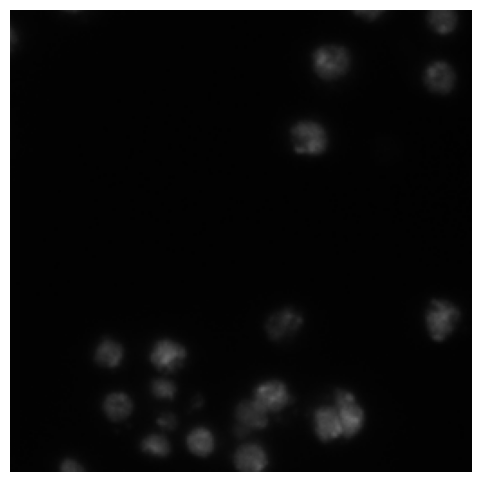


Image dimensions: (256, 256, 3)


In [12]:
from pathlib import Path

TRAIN_DIR = Path(DB_PATH + "extract/stage1_train/")

observations = os.listdir(TRAIN_DIR)
train_observations = observations[:-60]
sample = train_observations[0]

# for each observation, images/ contains one photo
image_f = sorted((TRAIN_DIR / sample).glob('images/*.png'))
print(f"Files found in 'images/': \n{image_f}")

image = imread(str(image_f[0]))

# plot with matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

print(f'\nImage dimensions: {image.shape}')

Files found in 'masks/': 
[WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png'), WindowsPath('database/extract/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png'), WindowsPath('database/extract/stage1_train/

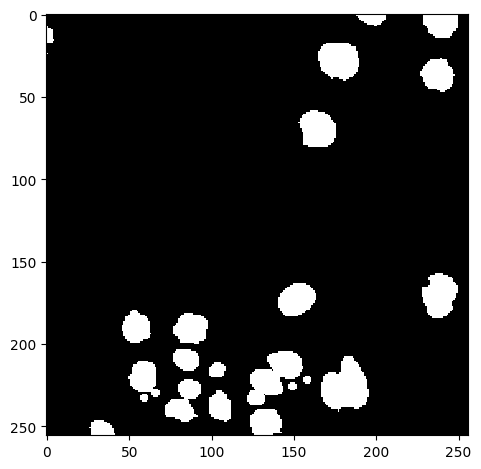

In [17]:
mask_files = sorted((TRAIN_DIR / sample).glob('masks/*.png'))
print(f"Files found in 'masks/': \n{mask_files}")

# insepcting an example of the masks
masks = imread_collection(sorted((TRAIN_DIR / observations[0]).glob('masks/*.png')))
imshow(np.sum(masks, axis=0).astype(np.uint8)) # combine masks 

print(f'\nNumber of masks: {len(masks)}')

In [18]:
from collections import namedtuple

def read_image(observation_id, directory):
    return imread(sorted((directory / observation_id).glob('images/*.png'))[0])

def read_masks(observation_id, directory):
    return imread_collection(sorted((directory / observation_id).glob('masks/*.png')))

# let's get some basic stats about our dataset 
Summary = namedtuple('Summary', ['observation_id', 'image_size', 'n_masks'])
train_data_summary = []

# create data frame of observation_id, image_size, n_masks
for observation_id in train_observations:
    train_data_summary.append(Summary(observation_id=observation_id,
                                      image_size=read_image(observation_id, TRAIN_DIR).shape,
                                      n_masks=len(read_masks(observation_id, TRAIN_DIR))
                                     )
                             )
    
df = pd.DataFrame(train_data_summary, columns=Summary._fields)
df.head()

,observation_id,image_size,n_masks
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"(256, 256, 4)",27
1,003cee89357d9fe13516167fd67b609a164651b2193458...,"(256, 256, 4)",36
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,"(256, 320, 4)",70
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,"(256, 320, 4)",86
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,"(256, 320, 4)",7


In [19]:
df['image_size'].value_counts()

image_size
(256, 256, 4)      296
(256, 320, 4)      104
(360, 360, 4)       86
(520, 696, 4)       86
(1024, 1024, 4)     16
(512, 640, 4)       12
(260, 347, 4)        5
(603, 1272, 4)       4
(1040, 1388, 4)      1
Name: count, dtype: int64

Max height: 534
Image size: (1040, 1388, 4)


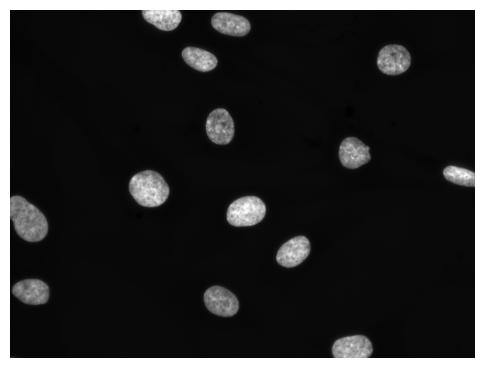

c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339


In [28]:
max_height = df['image_size'].apply(lambda x: x[0]).idxmax()
print(f'Max height: {max_height}')
print(f'Image size: {df.loc[max_height, "image_size"]}')

image = read_image(df.loc[max_height, 'observation_id'], TRAIN_DIR)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

print( df.loc[max_height].observation_id)

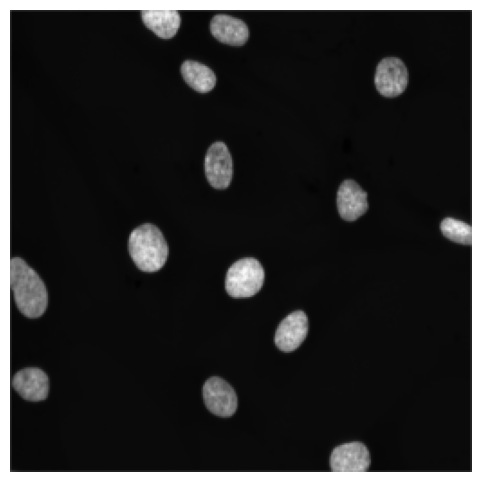

In [29]:
image_resized = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.figure(figsize=(6, 6))
plt.imshow(image_resized.astype(np.uint8))
plt.axis('off')
plt.show()

<Axes: ylabel='Frequency'>

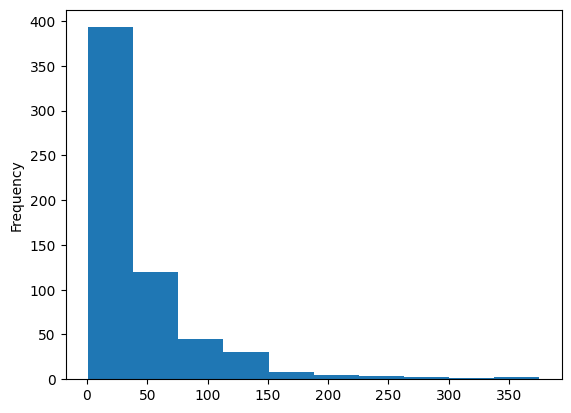

In [20]:
df['n_masks'].plot(kind='hist')

In [ ]:
x_train.shape, y_train.shape

((670, 256, 256, 3), (670, 128, 128, 1))

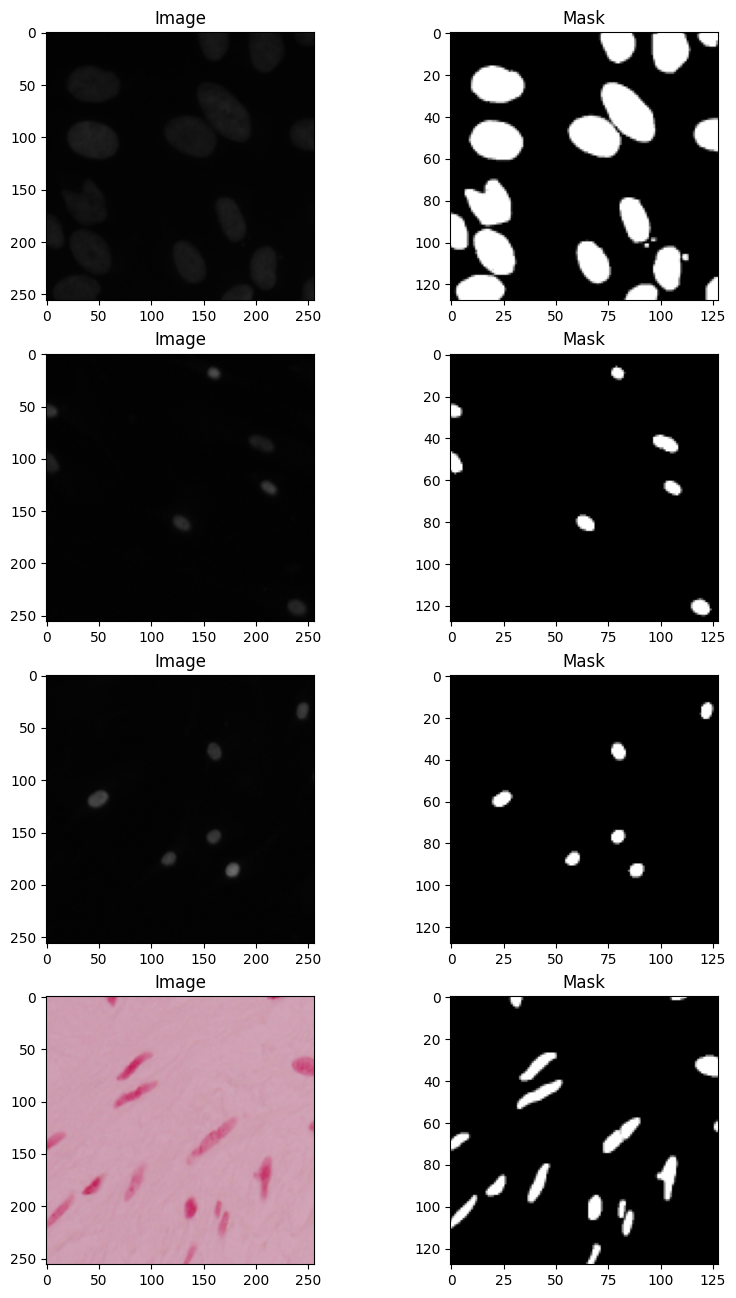

In [ ]:
plt.figure(figsize=(20, 16))

# take random 4 images
x, y = 4, 4
for i in range(y):
    index = random.randint(0, len(x_train))
    plt.subplot(y, x, i * x + 1)
    plt.imshow(x_train[index])
    plt.title('Image')

    plt.subplot(y, x, i * x + 2)
    plt.imshow(y_train[index].squeeze(), cmap='gray')
    plt.title('Mask')

## FIRST ATTEMPT

In [68]:
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch.transforms import ToTensorV2

def get_transforms(mean, std):
    list_transforms = []
    
    list_transforms.extend(
            [
        HorizontalFlip(p=0.5), # only horizontal flip as of now
            ])
    list_transforms.extend(
            [
    Normalize(mean=mean, std=std, p=1),
    ToTensorV2(),
            ])
    list_trfms = Compose(list_transforms)
    return list_trfms

class Nuclie_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)
    
    def __len__(self):
        return len(self.folders)
            
    
    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
        
        img = imread(image_path)[:,:,:3].astype('float32')
        img = resize(img,(128,128))
        
        mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

        augmented = self.transforms(image=img, mask=mask)
        # normalize to dim = 3
        img = augmented['image']
        mask = augmented['mask']
        mask = mask[0].permute(0, 3, 1, 2).unsqueeze(0)
        return (img,mask) 


    def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
        for mask_ in os.listdir(mask_folder):
                mask_ = imread(os.path.join(mask_folder,mask_))
                mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                mask_ = np.expand_dims(mask_,axis=-1)
                mask = np.maximum(mask, mask_)
            
        return mask
        

In [69]:
base_dir = DB_PATH + 'extract/stage1_train/'
data = Nuclie_data(base_dir)

In [70]:
print(data.__len__())
data.__getitem__(0)

#print the image and mask
img,mask = data.__getitem__(0)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0),cmap='gray')
plt.title('Mask')
plt.show()

670


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4

## SECOND ATTEMPT

## IMAGE TRAIN PREPROCESS

## DEFINE DATASET

In [ ]:
def overlay_masks(images_dir, subdir_name, target_dir):
    train_dir = os.path.join(images_dir, subdir_name)
    for mask_dirname in tqdm(glob.glob('{}/*/masks'.format(train_dir))):
        masks = []
        for image_filepath in glob.glob('{}/*'.format(mask_dirname)):
            image = np.asarray(Image.open(image_filepath))
            image = np.where(image > 0, 1, 0)
            masks.append(image)
        overlayed_masks = np.sum(masks, axis=0)
        overlayed_masks = np.where(overlayed_masks > 0, 1, 0)
        target_filepath = '/'.join(mask_dirname.replace(images_dir, target_dir).split('/')[:-1]) + '.png'
        os.makedirs(os.path.dirname(target_filepath), exist_ok=True)
        imwrite(target_filepath, overlayed_masks)

def preprocess_image(img, target_size=(128, 128)):
    img = resize(img, target_size, mode='constant')
    x = np.expand_dims(img, axis=0)
    x = x.transpose(0, 3, 1, 2)
    x = torch.FloatTensor(x)
    if torch.cuda.is_available():
        x = torch.autograd.Variable(x, volatile=True).cuda()
    else:
        x = torch.autograd.Variable(x, volatile=True)
    return x

def save_target_masks(target_filepath, *masks):
    with open(target_filepath, 'w') as file:
        json.dump(masks, file)

In [ ]:
class CellularDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_dir (string): Directory with all the labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.image_files = images
        self.label_files = labels

        # Ensure both directories have the same number of files
        assert len(self.image_files) == len(self.label_files), \
            "The number of images and labels should be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct file paths
        img_name = os.path.join(IMAGE_PATH, self.image_files[idx])
        label_name = os.path.join(LABEL_PATH, self.label_files[idx])

        # Load image and label
        image = Image.open(img_name).convert('RGB')
        label = Image.open(label_name).convert('L')
        
        # Convert to NumPy arrays
        image_np = np.array(image)
        label_np = np.array(label)

        if self.transform:
            image_np, label_np = self.transform(image_np, label_np)

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(image_np).float()
        label_tensor = torch.from_numpy(label_np).long()

        return image_tensor, label_tensor

## Create Dataset and Dataloader

In [ ]:
train_dataset = CellularDataset(train_images,train_labels)
val_dataset = CellularDataset(val_images,val_labels)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


## MODEL

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

METRICS

## Jaccard Index: Measuring Intersection Over Union (IoU)

The **Jaccard Index** is a metric used to compare the similarity between two sets. It calculates the ratio of the size of the intersection of the sets to the size of their union. Mathematically, it's defined as:

$$
J(A, B) = |A ∩ B| / |A ∪ B|
$$

## Jaccard Loss 

The **Jaccard Loss** is derived from the Jaccard index and serves as a loss function during model training. This loss function is particularly useful for image segmentation tasks where the goal is to optimize the model for accurate segmentation. It's defined as:

$$
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})
$$

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted and true values.


In [ ]:
def jaccard(preds, trues, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)

    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return jaccard(input, target, self.size_average)

## Dice Loss

The Dice Loss is a metric used to evaluate the performance of models in tasks like image segmentation. It focuses on the overlap between the predicted segmentation mask and the ground truth mask, penalizing models that incorrectly classify pixels.

A: Predicted segmentation mask pixels

B: Ground truth segmentation mask pixels

$$
L_Dice(A, B) = 1 - 2 * |A ∩ B| / (|A| + |B|)
$$

In [ ]:
def dice_loss(preds, trues, weight=None, is_average=True):
    preds = preds.contiguous()
    trues = trues.contiguous()
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (2. * intersection + EPS) / (preds.sum(1) + trues.sum(1) + EPS)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

def dice_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        return dice_loss(input, target, self.weight, self.size_average)

## TRAIN

In [ ]:
def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save(state, filename)

def load_ckp(checkpoint_fpath, model, optimizer):

    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint

In [ ]:
from tqdm import tqdm

train_loss = []
val_loss = []
accuracy_list = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.permute(0, 3, 1, 2).to(device)  # Transpose to [batch_size, channels, height, width]
        targets = targets.float().unsqueeze(1).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            train_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def check_accuracy(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.permute(0, 3, 1, 2).to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            val_loss.append(loss_fn(preds, y))

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    accuracy_list.append(num_correct/num_pixels*100)
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def fit(model, optimizer, loss_fn):
  for epoch in range(EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn)

    # check accuracy
    check_accuracy(val_loader, model, loss_fn, device=device)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(device)
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = JaccardLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
fit(model,optimizer,loss_fn)

In [ ]:
train_loss_cpu = [tensor.cpu().detach().numpy() for tensor in train_loss]
val_loss_cpu = [tensor.cpu().detach().numpy() for tensor in val_loss]
accuracy_list_cpu = [tensor.cpu().detach().numpy() for tensor in accuracy_list]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss_cpu, label='train_loss')
plt.plot(val_loss_cpu, label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(accuracy_list_cpu, label='accuracy')
plt.legend()
plt.show()

In [ ]:

def to_mask(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def to_image(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

In [ ]:
# load the model
model, optimizer, start_epoch = load_ckp(CHECKPOINT_PATH, model, optimizer)

In [ ]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)

model.eval()
# plot the image and mask

In [ ]:
image =  image.permute(0, 3, 1, 2).to(device)
# y_pred = model(image)